# Variational inference (VI) with TFP layers

__Objective:__ explore TFP layers that can be trained with VI (_Bayes by backprop_).

In [63]:
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import seaborn as sns

tfd = tfp.distributions

sns.set_theme()

## Generate data

Text(0.5, 1.0, 'Data')

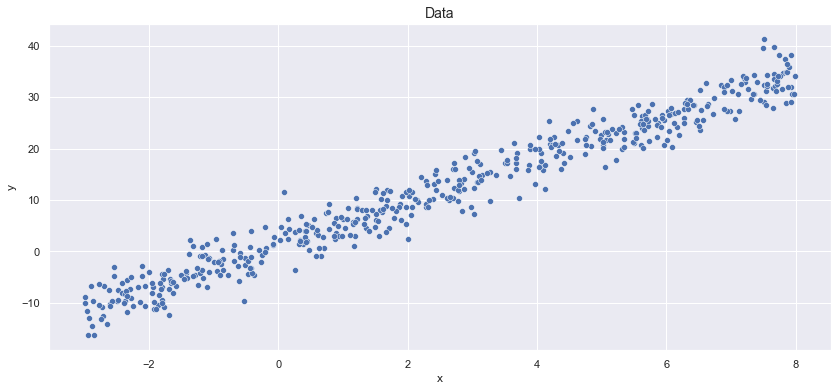

In [64]:
# Generate random datapoints normally distributed around a
# straight line.
n_datapoints = 500

x_data = tf.random.uniform(minval=-3., maxval=8., shape=(n_datapoints, 1))

a_true = 4.1
b_true = 1.2
sigma_data_true = 2.75

y_data = tf.squeeze(tfd.Normal(loc=x_data * a_true + b_true, scale=sigma_data_true).sample())


# Plot generated data.
fig = plt.figure(figsize=(14, 6))

sns.scatterplot(
    x=x_data[:, 0].numpy(),
    y=y_data.numpy()
)

plt.xlabel('x')
plt.ylabel('y')
plt.title('Data', fontsize=14)

## VI networks

VI networks are NNs whose weights are replaced with probability distributions that are trained using VI.

### Model building

In [344]:
num = x_data.shape[0]

model = tf.keras.Sequential([
    # One dense VI layer.
    tfp.layers.DenseReparameterization(
        units=1,
        # We explicitly add a prior and posterior for the bias parameter
        # because by default it's kept non-bayesian.
        bias_prior_fn=tfp.layers.util.default_multivariate_normal_fn,
        bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
        # The following 2 options are needed if we train with minibatch
        # SGD, in which case we need to rescale the KL part of the loss
        # to make sure the loss is applied once per epoch (`num` = number
        # of examples per epoch).
        # kernel_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (num * 1.),
        # bias_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (num * 1.),
    ),
    # Output layer (a distribution, for aleatoric uncertainty).
    # Note: we fit the `loc` (mu) parameter of the output distribution
    #       but assume the `scale` (sigma) parameter is fixed.
    tfp.layers.DistributionLambda(
        lambda t: tfd.Normal(loc=t[:, 0], scale=1.)
    )
])

In [345]:
# Test.
model(tf.random.uniform(shape=(35, 1)))

# The model should have 4 parameters, 2 for each variational
# distribution (i.e. for each of the "original" parameters),
# each distribution being a Gaussian.
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_reparameterization_13  (35, 1)                  4         
  (DenseReparameterization)                                      
                                                                 
 distribution_lambda_11 (Dis  ((35,),                  0         
 tributionLambda)             (35,))                             
                                                                 
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


/Users/Ema/anaconda3/envs/bayesian-explorations/lib/python3.9/site-packages/tensorflow_probability/python/layers/util.py:95: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  loc = add_variable_fn(
/Users/Ema/anaconda3/envs/bayesian-explorations/lib/python3.9/site-packages/tensorflow_probability/python/layers/util.py:105: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  untransformed_scale = add_variable_fn(


### Model training

In [346]:
def nll(y_true, distr):
    """
    NLL part of the loss function, computed for one sample.
    This is passed to the `compile` method of the model,
    which expects a callable taking the true
    value (first) and the predicted value (second) as inputs.
    In this case the predicted value is a distribution.
    """
    return - distr.log_prob(y_true)

In [347]:
learning_rate = 5e-3

model.compile(
    loss=nll,
    optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate)
)

In [348]:
epochs = 5000

hist = model.fit(
    x_data,
    y_data,
    epochs=epochs,
    verbose=0
)

Text(0, 0.5, 'Loss value')

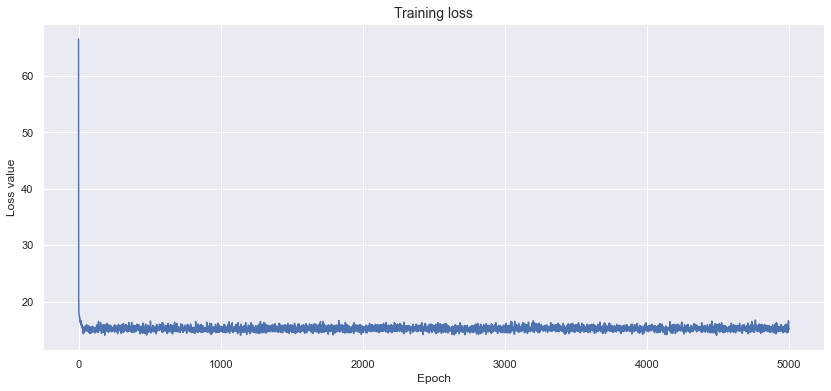

In [349]:
# Loss history
fig = plt.figure(figsize=(14, 6))

sns.lineplot(
    x=range(len(hist.history['loss'])),
    y=hist.history['loss']
)

plt.title('Training loss', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Loss value')

Estimated variational parameters:
mu_a: 4.016778469085693 | sigma_a: 0.23187685012817383 | mu_b: 0.8537858128547668 | sigma_b: 0.706741452217102

True values:
a: 4.1 | b: 1.2

Distance of the true values from the posterior means:
a: -0.35890358686447144 sigma | b: -0.4898739755153656 sigma


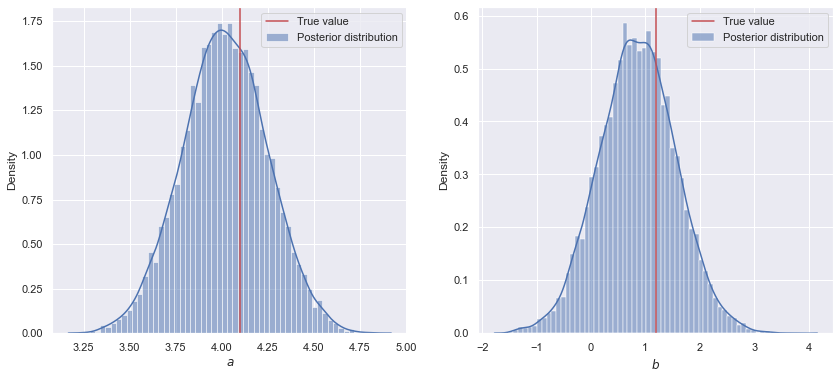

In [351]:
# Plot the variational distributions of the parameters and
# the true values.
print('Estimated variational parameters:')
print(
    f'mu_a: {tf.squeeze(model.layers[0].kernel_posterior.mean())} | '
    f'sigma_a: {tf.squeeze(model.layers[0].kernel_posterior.stddev())} | '
    f'mu_b: {tf.squeeze(model.layers[0].bias_posterior.mean())} | '
    f'sigma_b: {tf.squeeze(model.layers[0].bias_posterior.stddev())}'
)

print('\nTrue values:')
print(f'a: {a_true} | b: {b_true}')

z_a = (tf.squeeze(model.layers[0].kernel_posterior.mean()) - a_true) / tf.squeeze(model.layers[0].kernel_posterior.stddev())
z_b = (tf.squeeze(model.layers[0].bias_posterior.mean()) - b_true) / tf.squeeze(model.layers[0].bias_posterior.stddev())

print('\nDistance of the true values from the posterior means:')
print(f'a: {z_a} sigma | b: {z_b} sigma')


a_samples = tf.squeeze(model.layers[0].kernel_posterior.sample(10000))
b_samples = tf.squeeze(model.layers[0].bias_posterior.sample(10000))

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

sns.histplot(
    x=a_samples.numpy(),
    ax=axs[0],
    kde=True,
    stat='density',
    label='Posterior distribution'
)

axs[0].axvline(
    x=[a_true],
    ymin=0.,
    ymax=1.,
    color='r',
    label='True value'
)

plt.sca(axs[0])
plt.xlabel('$a$')
plt.legend()

sns.histplot(
    x=b_samples.numpy(),
    ax=axs[1],
    kde=True,
    stat='density',
    label='Posterior distribution'
)

axs[1].axvline(
    x=[b_true],
    ymin=0.,
    ymax=1.,
    color='r',
    label='True value'
)

plt.sca(axs[1])
plt.xlabel('$b$')
plt.legend()

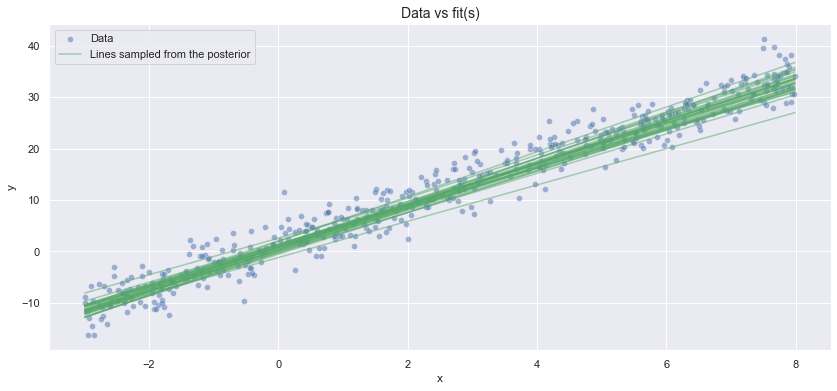

In [352]:
fig = plt.figure(figsize=(14, 6))

x_plot = tf.linspace(x_data.numpy().min(), x_data.numpy().max(), 100)

y_plot = tf.stack(
    [
        model(x_plot).mean() for _ in range(30)
    ],
    axis=0
)

sns.scatterplot(
    x=x_data[:, 0].numpy(),
    y=y_data.numpy(),
    alpha=.5,
    label='Data'
)

for line in range(y_plot.shape[0]):
    sns.lineplot(
        x=x_plot,
        y=y_plot[line, :],
        alpha=0.5,
        color='g',
        label='Lines sampled from the posterior' if line == 0 else None
    )
    
plt.xlabel('x')
plt.ylabel('y')
plt.title('Data vs fit(s)', fontsize=14)
plt.legend()